In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

#import stuff for gradCAM
import matplotlib.cm as cm
from IPython.display import Image

#Set GPU to use
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

TF version: 2.8.0
 GPU: /device:GPU:0


In [2]:
#set Image size (RGB so imshape is 3)
pix_dim = 224
imsize = (pix_dim,pix_dim) 
imshape = (pix_dim,pix_dim,3)

In [3]:
#load model
filepath = './models/mobilenetv2_water_18'
model = tf.keras.models.load_model(filepath, compile = True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

                                                                                                  
 dense_out (Dense)              (None, 1)            1025        ['dropout_4[0][0]']              
                                                                                                  
Total params: 6,719,553
Trainable params: 4,461,569
Non-trainable params: 2,257,984
__________________________________________________________________________________________________


In [4]:
last_conv_layer_name = "out_relu"
classifier_layer_names = [
    "GAP2D_1",
    "dense_1",
    "dropout_1",
    "dense_2",
    "dropout_2",
    "dense_3",
    "dropout_3",
    "dense_4",
    "dropout_4",
#    "dense_5",
#    "dropout_5",
#    "dense_6",
#    "dropout_6",
#    "dense_7",
#    "dropout_7",
    "dense_out"
]

In [5]:
#test one image

#flooded images

ip = 'CAM_BF_01_20211107125422'
#ip = "CAM_CB_01_20220514001822"
#ip = "CAM_BF_01_20211109145422"
#ip = "CAM_BF_01_20211107134222"
#ip = "CAM_BF_01_20220519032421"
#ip = "CAM_BF_01_20211108134822"

#not flooded images
#ip = "CAM_BF_01_20210828021222"
#ip = "CAM_BF_01_20210828013022"
#ip = "CAM_BF_01_20210828130021"
#ip = "CAM_BF_01_20210828192422"
#ip = "CAM_BF_01_20220515034822"
#ip = "CAM_BF_01_20220515214822"


impath = "labelled photos/water/" + str(ip) + ".jpg"
#impath = "labelled photos/no_water/" + str(ip) + ".jpg"

img = tf.keras.preprocessing.image.load_img(impath,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
img_array = np.expand_dims(img,axis=0)

#0-> not flooded
#1-> flooded
model.predict(img_array)

array([[0.91053104]], dtype=float32)

In [6]:
#test multiple images of one class from test dataset
test_dir_wash = "labelled photos/water/"

w_test = []
w_images = []

for img in os.listdir(test_dir_wash):
    #pull the name of the image
    w_images.append(img)
    #pull the image
    img = os.path.join(test_dir_wash, img)
    img = tf.keras.preprocessing.image.load_img(img,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    w_test.append(img)
    
#make predictions 
w_test = np.vstack(w_test)
w_preds = model.predict(w_test)

In [7]:
w_images = np.vstack((np.asarray(w_images)))
w_obs = np.vstack((np.full((1356,1), True)))
all_pred = np.vstack(w_preds)
results_df = pd.DataFrame(np.hstack((w_images, w_obs, all_pred)), columns=["Image", "Observed", "Predicted"])
results_df.to_csv('images/water_predictions.csv', index=False)
results_df.head()

,Image,Observed,Predicted
0,CAM_BF_01_20210804011222.jpg,True,0.9971649
1,CAM_BF_01_20210804011822.jpg,True,0.999793
2,CAM_BF_01_20210822032422.jpg,True,0.37666702
3,CAM_BF_01_20210822033022.jpg,True,0.9949346
4,CAM_BF_01_20211009143022.jpg,True,0.1982955


In [9]:
#test the model using all images

#define test directory
test_dir_wash = 'labelled photos/water'
test_dir_nowash = 'labelled photos/no_water'

#load images for wash
w_test = []
w_images = []
for img in os.listdir(test_dir_wash):
    #pull the name of the image
    w_images.append(img)
    #pull the image
    img = os.path.join(test_dir_wash, img)
    img = tf.keras.preprocessing.image.load_img(img,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    w_test.append(img)

#load images for nowash
nw_test = []
nw_images = []
for img in os.listdir(test_dir_nowash):
    #pull the name of the image
    nw_images.append(img)
    #pull the image
    img = os.path.join(test_dir_nowash, img)
    img = tf.keras.preprocessing.image.load_img(img,target_size = imsize)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255
    img = np.expand_dims(img,axis=0)
    nw_test.append(img)

#make predictions 
w_test = np.vstack(w_test)
w_preds = model.predict(w_test)

nw_test = np.vstack(nw_test)
nw_preds = model.predict(nw_test)

#stack up the predicitons and truth in the same format

#vstack pred array
all_pred = np.vstack((w_preds,nw_preds))
all_pred = all_pred > 0.5

#vstack true array
all_obs = np.vstack((np.full((1356,1), True), np.full((2365,1), False)))

#report relevant binary classification stats for test data
report = metrics.classification_report(all_obs, all_pred)
print(report)

              precision    recall  f1-score   support

       False       0.93      0.67      0.78      2365
        True       0.61      0.92      0.73      1356

    accuracy                           0.76      3721
   macro avg       0.77      0.79      0.76      3721
weighted avg       0.82      0.76      0.76      3721



In [10]:
#make labels into an array (wash then nowash)
nw_images = np.vstack((np.asarray(nw_images)))
w_images = np.vstack((np.asarray(w_images)))
all_images = np.vstack((w_images, nw_images))

#make single df for image names, true class, and predicted class 
#data = np.hstack((all_labels, all_true, all_pred))
results_df = pd.DataFrame(np.hstack((all_images, all_obs, all_pred)), columns=["Image", "Observed", "Predicted"])
results_df.head()

,Image,Observed,Predicted
0,CAM_BF_01_20210804011222.jpg,True,True
1,CAM_BF_01_20210804011822.jpg,True,True
2,CAM_BF_01_20210822032422.jpg,True,False
3,CAM_BF_01_20210822033022.jpg,True,True
4,CAM_BF_01_20211009143022.jpg,True,False


In [11]:
results_df.to_csv('images/mobilenetv2_water_18_2.csv', index=False)

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1582  783]
 [ 115 1241]]


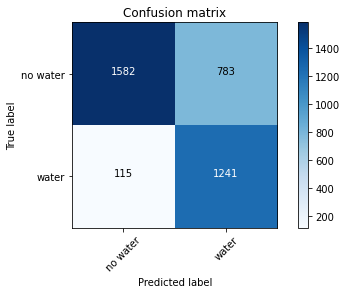

In [13]:
plot_confusion_matrix(cm = metrics.confusion_matrix(all_obs, all_pred), classes = ['no water', 'water'])

In [14]:
#from https://keras.io/examples/vision/grad_cam/

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = tf.keras.preprocessing.image.load_img(img_path, target_size = imsize)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    #grads = tape.gradient(bottom_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)
 
    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

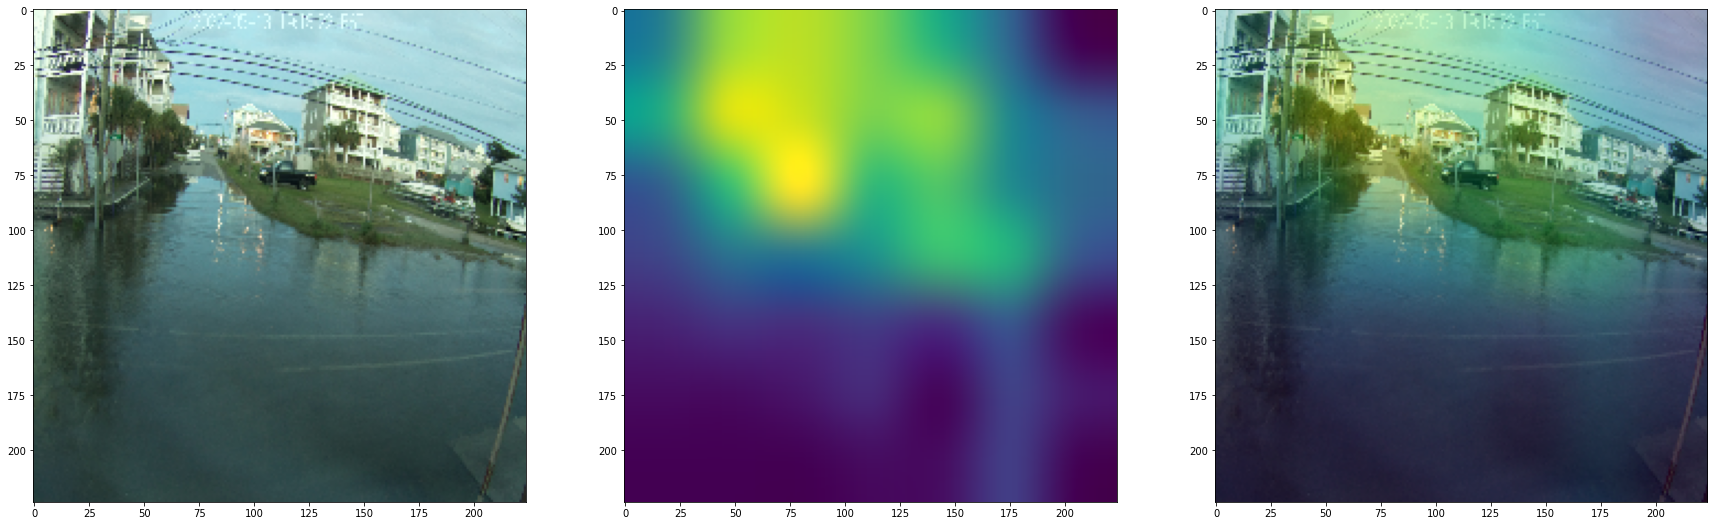

In [15]:
#from https://keras.io/examples/vision/grad_cam/
# Prepare image
#flooded images
#ip = 'CAM_BF_01_20211107125422'
#ip = "CAM_BF_01_20211109145422"
#ip = "CAM_BF_01_20211107134222"
#ip = "CAM_BF_01_20220519032421"
#ip = "CAM_BF_01_20211108134822"
ip = "CAM_CB_01_20220514001822"

#ip = "d (428)"

#not_flooded images

#ip = "CAM_BF_01_20210828021222"
#ip = "CAM_BF_01_20210828013022"
#ip = "CAM_BF_01_20210828130021"
#ip = "CAM_BF_01_20210828192422"
#ip = "CAM_BF_01_20220515034822"
#ip = "CAM_BF_01_20220515214822"



#image paths used

impath = "labelled photos/water/" + str(ip) + ".jpg"
#impath = "data/classification/not_flooded/" + str(ip) + ".jpg"
#impath = "data/sunnyday/" + str(ip) + ".jpg"

img = tf.keras.preprocessing.image.load_img(impath,target_size = imsize)
img = tf.keras.preprocessing.image.img_to_array(img)
img = img/255
img_array = np.expand_dims(img,axis=0)


# Make the heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names)
    
# get the original ERI image
Orimg = tf.keras.preprocessing.image.load_img(impath, target_size = imsize)
Orimg = tf.keras.preprocessing.image.img_to_array(Orimg)

# rescale image (range 0-255)
heatmap = np.uint8(255 * heatmap)

# use viridis for heatmap
vir = cm.get_cmap("viridis")
vir_colors = vir(np.arange(256))[:, :3]
vir_heatmap = vir_colors[heatmap]

# make the heatmap
vir_heatmap = tf.keras.preprocessing.image.array_to_img(vir_heatmap)
vir_heatmapI = vir_heatmap.resize((Orimg.shape[1], Orimg.shape[0]))
vir_heatmap = tf.keras.preprocessing.image.img_to_array(vir_heatmapI)

#put heatmpa on image
superimposed_img = vir_heatmap * 0.4 + Orimg
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

# Display Image, heatmap and overlay
# Display heatmap
plt.figure(figsize=(30,30))
plt.subplot(131)
plt.imshow(tf.keras.preprocessing.image.load_img(impath, target_size = imsize))
plt.subplot(132)
plt.imshow(vir_heatmapI)
plt.subplot(133)
plt.imshow(superimposed_img)
    
#save it
plt.savefig('images/FPgrad_{}mobilenetv2_water_20.png'.format(ip), format='png')